In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import itertools
from PIL import Image
from scipy.stats import logistic


# Name of the hdf file that contain the data we need
f_name = 'sxro6416-r0504.h5'

# Open the hdf5 file, use the path to the images to extrate the data and place
# it in the image data object for further manipulation and inspection.
datafile = h5py.File(f_name, 'r')
image_data = []
for i in itertools.count(start=0):
    d = datafile.get(f'Configure:0000/Run:0000/CalibCycle:{i:04d}/Princeton::FrameV2/SxrEndstation.0:Princeton.0/data')
    if d is not None:
        # actual image is at first index
        image_data.append(d[0])
    else:
        break

#print(image_data[1])
# Tell me how many images were contained in the datafile
print(f"loaded {len(image_data)} images")


#for i in range(20):
    #plt.imshow(image_data[i])
    #plt.savefig('image'+str(i)+'.png',dpi=1000)
    #image = Image.fromarray(image_data[i]).convert("L")
    #image.save("image"+str(i)+".png")

# Plot a good dataset - here index 8 (but there are others too!)
#misc.imshow(image_data[0])
#misc.show()

#image = Image.fromarray(image_data[0]).convert("L")
#image.save("out.png")

# The histogram of the data will help show possible single photon hits
plt.hist(image_data[1].flatten(), bins=100)
plt.yscale('log')


loaded 20 images


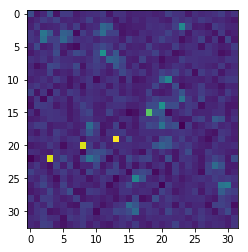

In [4]:
dat=image_data[1]
test_dat_2=dat[492:525,1308:1340].astype(int)-50
test_height_2=test_dat_2.shape[0]
test_width_2=test_dat_2.shape[1]

plt.imshow(test_dat_2)

In [134]:
### Define the distribution function of single photon events.

#Here, such distribution is modeled as Gaussian. Later this will be justified/replaced with more justified forms based on
#literatures and/or physical simulations

def dist_f_gaussian(x,y,x0,y0,s1,s2,A,t,cutoff=2):
    x1=(x-x0)*np.cos(t)-(y-y0)*np.sin(t)
    y1=(x-x0)*np.sin(t)+(y-y0)*np.cos(t)
    #print(x1,y1,x0,y0,s1,s2,A,t,cutoff)
    if(x1>=cutoff*s1 or y1>=cutoff*s2):
        return 0
    else:
        return A/s1/s2*np.exp(-x1**2/(2*s1**2)-y1**2/(2*s2**2))

#With respect to this distribution, we create a class of single photon events(SPE):
import math

class gaussian_spe:
    'A distribution of intensity caused by a single photon event'
    
    intensity_matrix=np.zeros((test_height_2,test_width_2))
    
    dist_fn='gaussian'
    
    def __init__(self, y0, x0, s1, s2, A, t=0, cutoff=2):
        self.x0 = x0
        self.y0 = y0
        self.s1 = s1
        self.s2 = s2
        self.A = A
        self.t = t
        self.cutoff = cutoff
        self.intensity_matrix=np.zeros((test_height_2,test_width_2))
        s=max([s1,s2])+0.5
        for i in range(test_height_2):
            for j in range(test_width_2):
                
                if(not((i<x0+cutoff*s and i>x0-cutoff*s) and (j<y0+cutoff*s and j>y0-cutoff*s))):
                    continue
                """
                #The simpson rule method
                
                x=np.linspace(i,i+1,sample_length)
                y=np.linspace(j,j+1,sample_length)
                #zz = self.dist(x.reshape(-1,1),y.reshape(1,-1))
                zz=np.zeros((sample_length,sample_length))
                for xi in range(sample_length):
                    for yi in range(sample_length):
                        zz[xi,yi]=self.dist(x[xi],y[yi])
                dist=lambda x,y: self.dist(x,y)
                #self.intensity_matrix[i,j]=integrate.dblquad(dist,i,i+1,lambda x:j,lambda x:j+1,epsabs=1e-4, epsrel=1e-4)[0]
                self.intensity_matrix[i,j]=simps([simps(zz_x,x) for zz_x in zz],y) 
                """
                
                #The MUCH SIMPLER erf method
                
                self.intensity_matrix[i,j]=1/2*np.pi*self.A*(math.erf((-self.x0+i)/math.sqrt(2)/s1)-math.erf((-self.x0+i+1)/math.sqrt(2)/s1))*(math.erf((-self.y0+j)/math.sqrt(2)/s2)-math.erf((-self.y0+j+1)/math.sqrt(2)/s2))
                
    
    def dist(self,x,y):
        return dist_f_gaussian(x,y,self.x0,self.y0,self.s1,self.s2,self.A,self.t,self.cutoff)
    
    def new_value(self, y0, x0, s1, s2, A, t=0, cutoff=2):
        self.x0 = x0
        self.y0 = y0
        self.s1 = s1
        self.s2 = s2
        self.A = A
        self.t = t
        self.cutoff = cutoff
        s=max([s1,s2])+1.5
        for i in range(test_height_2):
            for j in range(test_width_2):
                #The simpson rule method
                
                if(not((i<x0+cutoff*s and i>x0-cutoff*s) and (j<y0+cutoff*s and j>y0-cutoff*s))):
                    continue
                
                """
                x=np.linspace(i,i+1,sample_length)
                y=np.linspace(j,j+1,sample_length)
                #zz = self.dist(x.reshape(-1,1),y.reshape(1,-1))
                zz=np.zeros((sample_length,sample_length))
                for xi in range(sample_length):
                    for yi in range(sample_length):
                        zz[xi,yi]=self.dist(x[xi],y[yi])
                dist=lambda x,y: self.dist(x,y)
                #self.intensity_matrix[i,j]=integrate.dblquad(dist,i,i+1,lambda x:j,lambda x:j+1,epsabs=1e-4, epsrel=1e-4)[0]
                self.intensity_matrix[i,j]=simps([simps(zz_x,x) for zz_x in zz],y) 
                """
                
                #The MUCH SIMPLER erf method
                
                self.intensity_matrix[i,j]=1/2*np.pi*self.A*(math.erf((-self.x0+i)/math.sqrt(2)/s1)-math.erf((-self.x0+i+1)/math.sqrt(2)/s1))*(math.erf((-self.y0+j)/math.sqrt(2)/s2)-math.erf((-self.y0+j+1)/math.sqrt(2)/s2))
                
    
    def copy(self):
        return self
                
from scipy import integrate
import time

# The error function. It is defined as ...; the minimisation of which is the ultimate goal of this part of the code. 
def error(spe__array,dat_tag,input_dat=test_dat_2):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

def global_error(spe__array, input_dat=test_dat_2):
    matrix=input_dat
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[i,j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

In [135]:
class tag:
    'used to tag SPEs.'
    lx=0
    ly=0
    rx=0
    ry=0
    width=0
    height=0
    
    def __init__(self,lx,ly,rx,ry):
        self.lx=lx
        self.ly=ly
        self.rx=rx
        self.ry=ry
        self.width=rx-lx
        self.height=ry-ly
    
    def param(self):
        return [self.lx,self.ly,self.rx,self.ry]
    
    def hw(self):
        return [self.height,self.width]
    
def thresholding(dataset,threshold):
    label_matrix=np.zeros(dataset.shape)
    for i in range(dataset.shape[0]):
        for j in range(dataset.shape[1]):
            if(dataset[i,j]>=threshold):
                label_matrix[i,j]=1
    return label_matrix
    
from copy import deepcopy
    
def boxing(thres_matrix):
    lm=deepcopy(thres_matrix);

    def search(x,y):
        lefttop_x=x-1
        lefttop_y=y-1
        rightbot_x=x+1
        rightbot_y=y+1
        if(lm[x,y]==0):
            return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
        else:
            lm[x,y]=0
        for i in [x-2,x-1,x,x+1,x+2]:
            for j in [y-2,y-1,y,y+1,y+2]:
                if((i>=lm.shape[0]) or (j>=lm.shape[1])):
                    continue
                elif(lm[i,j]==1):
                    [a,b,c,d]=search(i,j)
                    #print([a,b,c,d])
                    lm[i,j]=0
                    lefttop_x=min([lefttop_x,a])
                    lefttop_y=min([lefttop_y,b])
                    rightbot_x=max([rightbot_x,c])
                    rightbot_y=max([rightbot_y,d])
                    #print('a',[lefttop_x,lefttop_y,rightbot_x,rightbot_y])
       
        return [lefttop_x,lefttop_y,rightbot_x,rightbot_y]
    #[lx,ly,rx,ry]=search(17,20,lm)
    #thres_matrix[lx,ly]=2
    #thres_matrix[rx,ry]=2
    #plt.imshow(thres_matrix)
    
    
    tag_list=[]
    
    flag=0

    while(True):
        for i in range(thres_matrix.shape[0]):
            for j in range(thres_matrix.shape[1]):
                if(lm[i,j]==1):
                    flag=1
                    [lx,ly,rx,ry]=search(i,j)
                    thres_matrix[lx,ly]=2
                    thres_matrix[rx,ry]=2
                    t=tag(lx,ly,rx,ry)
                    tag_list.append(t)
                    break
            if(flag==1):
                break
        if(flag==0):
            break
        flag=0
    return tag_list



In [144]:
import random

smin=0.25
smax=0.5

Amin=50
Amax=250

tmin=0
tmax=np.pi

def error(spe__array,dat_tag,input_dat=test_dat_2):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                #print(event.intensity_matrix.shape)
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(matrix[i,j]-tot_intensity_matrix[i,j])**2
        
    return err

#sample_length=40

def gradient_descent_single(input_dat,dat_tag,output='verbose'):
    l=dat_tag.param()[0]
    r=dat_tag.param()[2]+1
    t=dat_tag.param()[1]
    b=dat_tag.param()[3]+1
    dat=input_dat[l:r,t:b]
    #return dat
    #print(dat)
    [i0,i1]=np.unravel_index(dat.argmax(),dat.shape)
    
    #return index
    xavg=0
    yavg=0
    for i in range(dat.shape[0]):
        for j in range(dat.shape[1]):
            xavg=xavg+i*dat[i,j]
            yavg=yavg+j*dat[i,j]
    
    x=l+xavg/sum(dat.flatten())+0.5
    y=t+yavg/sum(dat.flatten())+0.5
    
    #x=l+i0+0.5
    #y=t+i1+0.5
    
    if(output=='verbose'):
        print(x,y)    
       
    print(dat)
    
    #s_x=random.uniform(smin,smax)
    #s_y=random.uniform(smin,smax)
    #A=random.uniform(Amin,Amax)
    
    s_x=0.25+0.25*(dat[i0+1,i1]+dat[i0-1,i1])/dat[i0,i1]
    s_y=0.25+0.25*(dat[i0,i1+1]+dat[i0,i1-1])/dat[i0,i1]
    
    #s_x=0.4
    #s_y=0.4
    #A=dat.max()
    A=15
    
    spe=gaussian_spe(y,x,s_x,s_y,A)
    #print([x,y,s_x,s_y,A])
    #print(l,r,t,b)
    if(output=='verbose'):
        print(spe.intensity_matrix[l:r,t:b].astype(int))
    
    
    err=error([spe],dat_tag,input_dat)
    #print(err)
    
    step_xy=0.01
    step_s=0.005
    step_A=0.3
    descent_factor=0.05
    
    err_array=[]
    
    #print([x,y,s_x,s_y,A])
    
    for i in range(100):
        err=error([spe],dat_tag,input_dat)
        p_x=error([gaussian_spe(y,x+step_xy,s_x,s_y,A)],dat_tag,input_dat)-err
        p_y=error([gaussian_spe(y+step_xy,x,s_x,s_y,A)],dat_tag,input_dat)-err
        p_sx=error([gaussian_spe(y,x,s_x+step_s,s_y,A)],dat_tag,input_dat)-err
        p_sy=error([gaussian_spe(y,x,s_x,s_y+step_s,A)],dat_tag,input_dat)-err
        p_A=error([gaussian_spe(y,x,s_x,s_y,A+step_A)],dat_tag,input_dat)-err
        x=x-p_x*descent_factor*step_xy
        y=y-p_y*descent_factor*step_xy
        s_x=s_x-p_sx*descent_factor*step_s
        s_y=s_y-p_sy*descent_factor*step_s
        A=A-p_A*descent_factor*step_A
        spe=gaussian_spe(y,x,s_x,s_y,A)
        err_array.append(err)
        
        if(i>=11 and np.abs(err-err_array[i-11])<=err/40):
            print('convergence achieved at step ',i)
            if(output=='verbose'):
                print(err,err_array[i-11])
            break
        
        
        if(i%5==0 and output=='verbose'):
            print([x,y,s_x,s_y,A])
        #if(err<=200):
            #print('target reached')
            #break
    if(err>len(dat.flatten())*100):
        flag=1
    else:
        flag=0
    
    if(output=='verbose'):
        plt.plot(err_array)

    print(spe.intensity_matrix[l:r,t:b].astype(int))
    return [x,y,s_x,s_y,A,flag]
    #print(err)
        
    


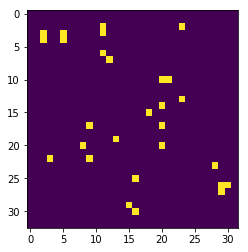

In [137]:
l2=thresholding(test_dat_2,30)
l2l=thresholding(test_dat_2,60)

tag_list=boxing(deepcopy(l2))

plt.imshow(l2)

In [158]:
def error(spe__array,dat_tag,input_dat=test_dat_2):
    matrix=input_dat[(dat_tag.param()[0]):(dat_tag.param()[2]+1),(dat_tag.param()[1]):(dat_tag.param()[3]+1)]
    #print(matrix)
    height=matrix.shape[0]
    width=matrix.shape[1]
    tot_intensity_matrix=np.zeros((height,width))
    err=0
    for i in range(height):
        for j in range(width):
            for event in spe__array:
                tot_intensity_matrix[i,j]=tot_intensity_matrix[i,j]+event.intensity_matrix[dat_tag.param()[0]+i,dat_tag.param()[1]+j]
            err=err+(input_dat[dat_tag.param()[0]+i,dat_tag.param()[1]+j]-tot_intensity_matrix[i,j])**2
        
    return err

#MPEs: 4 7 10

#Method I: simultaneous grad des

mpe_tag_list=[tag_list[4],tag_list[7],tag_list[10]]

def gradient_descent_multi(dat_tag,photon_n,input_dat=test_dat_2,output='verbose'):
    l=dat_tag.param()[0]
    r=dat_tag.param()[2]+1
    t=dat_tag.param()[1]
    b=dat_tag.param()[3]+1
    dat=input_dat[l:r,t:b]
    #return dat
    if(output=='verbose'):
        print(dat)
    #[i0,i1]=np.unravel_index(dat.argmax(),dat.shape)
    
    x_init=np.zeros(photon_n)
    y_init=np.zeros(photon_n)
    s_x=np.zeros(photon_n)
    s_y=np.zeros(photon_n)
    A=np.zeros(photon_n)
    
    dat_tmp=deepcopy(dat)
    spe_array=[]
    for n in range(photon_n):
        tmp=0
        x=0
        y=0
        for i in range(dat.shape[0]):
            for j in range(dat.shape[1]):
                if(dat_tmp[i,j]>tmp):
                    tmp=dat[i,j]
                    x=i
                    y=j
                    
        x_init[n]=x+l+0.5
        y_init[n]=y+t+0.5
        
        #s_x[n]=0.25+0.25*(input_dat[x+l+1,y+t]+input_dat[x+l-1,y+t]+input_dat[x+l+1,y+t+1]+input_dat[x+l-1,y+t+1]+input_dat[x+l+1,y+t-1]+input_dat[x+l-1,y+t-1])/(input_dat[x+l,y+t+1]+input_dat[x+l,y+t-1]+input_dat[x+l,y+t])
        #s_y[n]=0.25+0.25*(input_dat[x+l,y+t+1]+input_dat[x+l,y+t-1]+input_dat[x+l+1,y+t+1]+input_dat[x+l-1,y+t+1]+input_dat[x+l+1,y+t-1]+input_dat[x+l-1,y+t-1])/(input_dat[x+l-1,y+t]+input_dat[x+l+1,y+t]+input_dat[x+l,y+t])
        
        if(x < dat.shape[0]-1):
            s_x[n]=0.25+0.25*(dat[x+1,y]+dat[x-1,y])/dat[x,y]
        else:
            s_x[n]=0.25+0.25*(dat[x-1,y])/dat[x,y]
            
        if(y < dat.shape[1]-1):
            s_y[n]=0.25+0.25*(dat[x,y+1]+dat[x,y-1])/dat[x,y]
        else:
            s_y[n]=0.25+0.25*dat[x,y-1]/dat[x,y]
    
        #s_x[n]=0.4
        #s_y[n]=0.4
        
        A[n]=15        
        
        spe=gaussian_spe(y_init[n],x_init[n],s_x[n],s_y[n],A[n])
        spe_array.append(spe)
        dat_tmp[x,y]=0
        #print(dat_tmp)
        if(output=='verbose'):
            print([x,y,s_x[n],s_y[n],A[n]])
            print(spe.intensity_matrix[l:r,t:b].astype(int))
    print(x_init,y_init)
    #print(spe_array)
    
    
    
    """
    
    #return index
    xavg=0
    yavg=0
    for i in range(dat.shape[0]):
        for j in range(dat.shape[1]):
            xavg=xavg+i*dat[i,j]
            yavg=yavg+j*dat[i,j]
    
    x=l+xavg/sum(dat.flatten())+0.5
    y=t+yavg/sum(dat.flatten())+0.5
    
    #x=l+i0+0.5
    #y=t+i1+0.5
    
    if(output=='verbose'):
        print(x,y)    
        print(dat)
    
    #s_x=random.uniform(smin,smax)
    #s_y=random.uniform(smin,smax)
    #A=random.uniform(Amin,Amax)
    
    s_x=0.25+0.25*(dat[i0+1,i1]+dat[i0-1,i1])/dat[i0,i1]
    s_y=0.25+0.25*(dat[i0,i1+1]+dat[i0,i1-1])/dat[i0,i1]
    
    #s_x=0.4
    #s_y=0.4
    #A=dat.max()
    A=15
    
    spe=gaussian_spe(y,x,s_x,s_y,A)
    #print([x,y,s_x,s_y,A])
    #print(l,r,t,b)
    if(output=='verbose'):
        print(spe.intensity_matrix[l:r,t:b].astype(int))
    
    """
    
    
    #print(err)
    
    step_xy=0.01
    step_s=0.005
    step_A=0.3
    descent_factor=0.05
    
    err_array=[]
    
    #print([x,y,s_x,s_y,A])
    
    #s_x[1]=0.5
    
    for i in range(400):
        err=error(spe_array,dat_tag,input_dat)
        #print(x_init,y_init,s_x,s_y,A)
        p_x=np.zeros(photon_n)
        p_y=np.zeros(photon_n)
        p_sx=np.zeros(photon_n)
        p_sy=np.zeros(photon_n)
        p_A=np.zeros(photon_n)
        
        for n in range(photon_n):
            spe_array[n].new_value(y_init[n]+step_xy,x_init[n],s_x[n],s_y[n],A[n])
            p_y[n]=error(spe_array,dat_tag,input_dat)-err
            spe_array[n].new_value(y_init[n],x_init[n]+step_xy,s_x[n],s_y[n],A[n])
            p_x[n]=error(spe_array,dat_tag,input_dat)-err
            spe_array[n].new_value(y_init[n],x_init[n],s_x[n]+step_s,s_y[n],A[n])
            p_sx[n]=error(spe_array,dat_tag,input_dat)-err
            spe_array[n].new_value(y_init[n],x_init[n],s_x[n],s_y[n]+step_s,A[n])
            p_sy[n]=error(spe_array,dat_tag,input_dat)-err
            spe_array[n].new_value(y_init[n],x_init[n],s_x[n],s_y[n],A[n]+step_A)
            p_A[n]=error(spe_array,dat_tag,input_dat)-err
            spe_array[n].new_value(y_init[n],x_init[n],s_x[n],s_y[n],A[n])
            #print([p_y[n],p_x[n],p_sx[n],p_sy[n],p_A[n]])
        
        
        
        x_init=x_init-p_x*descent_factor*step_xy
        y_init=y_init-p_y*descent_factor*step_xy
        s_x=s_x-p_sx*descent_factor*step_s
        s_y=s_y-p_sy*descent_factor*step_s
        A=A-p_A*descent_factor*step_A
        
        for n in range(photon_n):
            spe_array[n].new_value(y_init[n],x_init[n],s_x[n],s_y[n],A[n])
        
        err_array.append(err)
        if(i>=11 and np.abs(err-err_array[i-11])<=err/40):
            if(err>len(dat.flatten())*100):
                print('suspicious case')
            if(output=='verbose'):
                print(err,err_array[i-11])
            break
            
    if(output=='verbose'):
        plt.plot(err_array)
        print(x_init,y_init,s_x,s_y,A)

    for spe in spe_array:
        print(spe.intensity_matrix[l:r,t:b].astype(int))
    if(output=='verbose'):
        print(err)
    
    return [x_init.flatten(),y_init.flatten(),A.flatten(),err]
    

[[ -5   3  13   7   7]
 [ -1  17  18  67  18]
 [ -2 109  27  25 -17]
 [  7   6   8  21  11]
 [  4  17  14  45  16]
 [  1   1   1   2   0]]
[2, 1, 0.30275229357798167, 0.3073394495412844, 15.0]
[[ 0  0  0  0  0]
 [ 0  4  0  0  0]
 [ 4 76  4  0  0]
 [ 0  4  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
[1, 3, 0.3694029850746269, 0.3843283582089552, 15.0]
[[ 0  0  0  6  0]
 [ 0  0  7 62  7]
 [ 0  0  0  6  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
[4, 3, 0.37777777777777777, 0.41666666666666663, 15.0]
[[ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]
 [ 0  0  1  6  1]
 [ 0  0  8 59  8]
 [ 0  0  1  6  1]]
[2, 2, 0.4907407407407407, 1.4907407407407407, 15.0]
[[ 0  0  0  0  0]
 [ 1  3  3  3  1]
 [ 7 13 17 13  7]
 [ 1  3  3  3  1]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]
[15.5 14.5 17.5 15.5] [18.5 20.5 20.5 19.5]
1307.4496675497662 1339.775212556663
[15.36311392 14.48358581 17.27283386 15.5294099 ] [18.65713601 20.49216407 20.54624748 19.46631768] [0.30497344 0.38186302 0.4168

[array([15.36311392, 14.48358581, 17.27283386, 15.5294099 ]),
 array([18.65713601, 20.49216407, 20.54624748, 19.46631768]),
 array([19.44451894, 17.33287006, 15.52096569, 13.72856065]),
 1307.4496675497662]

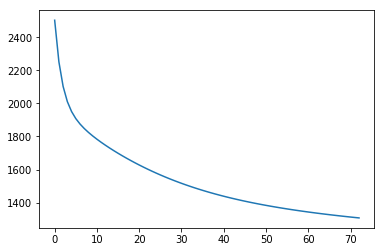

In [181]:
gradient_descent_multi(mpe_tag_list[1],4)

In [236]:
def spe_processing(threshold=30,input_dat=test_dat_2):
    tag_list=boxing(thresholding(deepcopy(input_dat),threshold))
    dat=deepcopy(input_dat)
    
    xy_list=[]
    
    for tag in tag_list:
        print('-----------------')
        if(tag.hw()[0]<=4 and tag.hw()[1]<=4):
            spe_event=gradient_descent_single(input_dat, tag, 'not verbose')
            [x,y,flag]=[spe_event[0],spe_event[1],spe_event[-1]]
            if(flag==0):
                xy_list.append([x,y])
                continue
        print('Shit just became multi')
        
        tmp=114514
        
        for n in [2,3,4,5,6]:
            
            print(n)
            if(n>2):
                spe_event_multi=spe_event_multi_new
            spe_event_multi_new=gradient_descent_multi(tag,n,input_dat,'not verbose')
            #print(spe_event_multi)
            
            if(spe_event_multi_new[-1]<tmp):
                if(min(spe_event_multi_new[2])>10):
                    tmp=spe_event_multi_new[-1]
                    continue
            
            print(spe_event_multi[-1])
            xy_list.append([spe_event_multi[0],spe_event_multi[1]])
                
            break
            
        
    return xy_list


In [211]:
start=time.time()
spe_result=spe_processing()
print(spe_result)
end=time.time()
print(end-start)

-----------------
[[-3  4  1]
 [ 1 37 29]
 [18 41 12]
 [-4  3  2]]
convergence achieved at step  47
[[ 0  0  0]
 [ 3 40 19]
 [ 3 38 18]
 [ 0  1  0]]
-----------------
[[  8   2   6]
 [ 11  60  11]
 [  0   7 -11]]
convergence achieved at step  79
[[ 0  4  0]
 [10 59  6]
 [ 0  0  0]]
-----------------
[[ 7 -6 -4]
 [-4 47 28]
 [ 1 43 11]
 [16 -7 -3]]
convergence achieved at step  45
[[ 0  0  0]
 [ 1 49 21]
 [ 1 38 16]
 [ 0  0  0]]
-----------------
[[ -2   7  -4]
 [ -3  32  27]
 [ 11  36  17]
 [ 13  -5 -13]]
convergence achieved at step  52
[[ 0  0  0]
 [ 2 34 20]
 [ 2 33 19]
 [ 0  0  0]]
-----------------
[[10 17  9 -4]
 [15 68  4 25]
 [13  2 33 29]
 [10  6 -5 26]]
convergence achieved at step  27
suspicious case
[[ 0  0  0  0]
 [ 0 66 13  0]
 [ 0 12  2  0]
 [ 0  0  0  0]]
Shit just became multi
2
[6.5 7.5] [11.5 12.5]
[[ 4 18  0  0]
 [16 66  1  0]
 [ 0  1  0  0]
 [ 0  0  0  0]]
[[ 0  0  0  0]
 [ 0  0  9 10]
 [ 0  1 30 33]
 [ 0  0  3  3]]
3
[6.5 7.5 7.5] [11.5 12.5 13.5]
[[ 4 17  0  0]
 

In [254]:
x_list=[]
y_list=[]

for element in spe_result:
    if(type(element[0])==np.ndarray):
        for i in range(len(element[0])):
            x_list.append(element[0][i])
            y_list.append(element[1][i])
    else:
        x_list.append(element[0])
        y_list.append(element[1])
        
xy_list=[x_list,y_list]
print(xy_list)

[[2.978999674370747, 2.4060597539823214, 3.9339510282125323, 3.9888039775808073, 6.260060767803326, 7.353523138842004, 10.387474445814265, 13.188065301748267, 15.370347502995244, 14.651334617781668, 17.220946604141613, 17.852367241580296, 19.400942983287333, 20.48812391551036, 22.244251655571425, 20.139693497425288, 22.491349737435367, 23.44593656226762, 25.289554199423634, 26.799245828806303, 29.96921658384428], [11.767694140494637, 23.438527476368964, 2.7935804266303736, 5.818255488228876, 11.286280503222677, 13.036183234641182, 21.129633937924066, 23.338348029857062, 18.707448393305345, 20.450704556003323, 20.53831288195919, 9.745757010895565, 13.508593511859345, 8.599850047873865, 9.785662572203053, 20.842898684201316, 3.5950738027475415, 28.71651632393545, 16.82851050624083, 29.986972312329588, 15.97352479719505]]


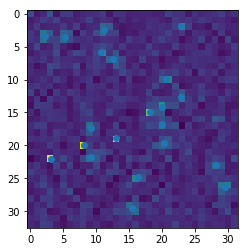

In [255]:
x_arr=np.array(x_list)-0.5
y_arr=np.array(y_list)-0.5

plt.imshow(test_dat_2)
#plt.scatter(xy_list[1],xy_list[0])
plt.scatter(y_arr,x_arr)

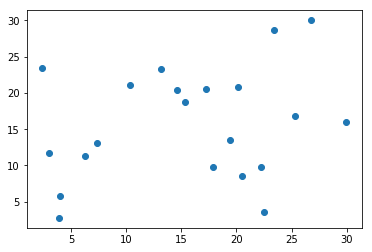

In [246]:
plt.scatter(xy_list[0],xy_list[1])